In [39]:
import os
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import trange
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

import syclib.utils as utils
from syclib.cluster import ClusterSC
from syclib import Matrix, SyntheticControl

ITERS = 1
k = 2  # number of clusters
cluster_method = "kmeans"
lmbda = 0.1
scale = False
methods = ["ols", "ridge", "lasso"]

data_path = "./hpi_clean_1997_2006.csv"
all_df = pd.read_csv(data_path)


# SET PARAMETERS
T = all_df.shape[1]  # 40
T0 = 36
threshold = 0.9
method = "lasso"

In [ ]:
print(f"Processing: T0={T0}, threshold={threshold}, method={method}")
all_mses = []
for iter in trange(ITERS):
    # Split data
    train_df, test_df = train_test_split(
        all_df, test_size=0.2, random_state=iter
    )

    # Scaling (if enabled)
    if scale:
        scaler = StandardScaler()
        train_df_scaled = pd.DataFrame(
            scaler.fit_transform(train_df),
            columns=train_df.columns,
            index=train_df.index,
        )
        test_df_scaled = pd.DataFrame(
            scaler.transform(test_df),
            columns=test_df.columns,
            index=test_df.index,
        )
    else:
        train_df_scaled = train_df
        test_df_scaled = test_df

    # Compute benchmark rank
    s = utils.singval_test(train_df, train_df.shape[0], show=False)
    r = utils.get_approx_rank(s, threshold)

    # Cluster donors
    csc = ClusterSC(train_df_scaled)
    csc.perform_clustering(k=k, random_state=0, method=cluster_method)
    r_s = [
        utils.get_approx_rank(
            utils.singval_test(
                train_df.loc[csc.get_donor_group(i).index],
                train_df.loc[csc.get_donor_group(i).index].shape[0],
                show=False,
            ),
            threshold,
        )
        for i in range(k)
    ]

    # Evaluate on test set
    mses = {
        "target_id": test_df.index.tolist(),
        "bench_train": [],
        "bench_test": [],
        "cluster_train": [],
        "cluster_test": [],
        "random_train": [],
        "random_test": [],
        "donor_group": [],
    }

    for target_id in test_df.index:
        target_data = test_df.loc[[target_id]]
        target_pre_scaled = test_df_scaled.iloc[
            test_df.index.get_loc(target_id), :T0
        ]

        # Benchmark dataset
        donor_data = pd.concat([target_data, train_df], axis=0)

        # Cluster assignment
        cluster = csc.predict_target_cluster(target_pre_scaled)
        selected_donor = train_df.loc[csc.get_donor_group(cluster).index]
        selected_r = r_s[cluster]
        mses["donor_group"].append(cluster)

        # Cluster-based SC
        cluster_dataset = pd.concat([target_data, selected_donor], axis=0)
        M = Matrix(cluster_dataset.T, T0=T0, target_name=target_id)
        M.denoise(num_sv=selected_r, transform=False)
        cluster_SC = SyntheticControl()
        cluster_SC.fit(
            M.pre_donor, M.pre_target, method=method, lmbda=lmbda
        )
        mses["cluster_train"].append(
            cluster_SC.predict_and_mse(M.pre_donor, M.pre_target)
        )
        mses["cluster_test"].append(
            cluster_SC.predict_and_mse(M.post_donor, M.post_target)
        )

        # Random donor SC
        random_donors = train_df.sample(
            n=len(selected_donor), random_state=0
        )
        random_dataset = pd.concat([target_data, random_donors], axis=0)
        random_r = utils.get_approx_rank(
            utils.singval_test(
                random_donors, len(random_donors), show=False
            ),
            threshold,
        )
        M_rand = Matrix(random_dataset.T, T0=T0, target_name=target_id)
        M_rand.denoise(num_sv=random_r, transform=False)
        rand_SC = SyntheticControl()
        rand_SC.fit(
            M_rand.pre_donor,
            M_rand.pre_target,
            method=method,
            lmbda=lmbda,
        )
        mses["random_train"].append(
            rand_SC.predict_and_mse(M_rand.pre_donor, M_rand.pre_target)
        )
        mses["random_test"].append(
            rand_SC.predict_and_mse(M_rand.post_donor, M_rand.post_target)
        )

        # Benchmark SC
        M_bench = Matrix(donor_data.T, T0, target_name=target_id)
        M_bench.denoise(num_sv=r, transform=False)
        bench_SC = SyntheticControl()
        bench_SC.fit(
            M_bench.pre_donor,
            M_bench.pre_target,
            method=method,
            lmbda=lmbda,
        )
        mses["bench_train"].append(
            bench_SC.predict_and_mse(M_bench.pre_donor, M_bench.pre_target)
        )
        mses["bench_test"].append(
            bench_SC.predict_and_mse(
                M_bench.post_donor, M_bench.post_target
            )
        )

    all_mses.append(mses)

Processing: T0=36, threshold=0.9, method=lasso


100%|██████████| 1/1 [00:10<00:00, 10.76s/it]


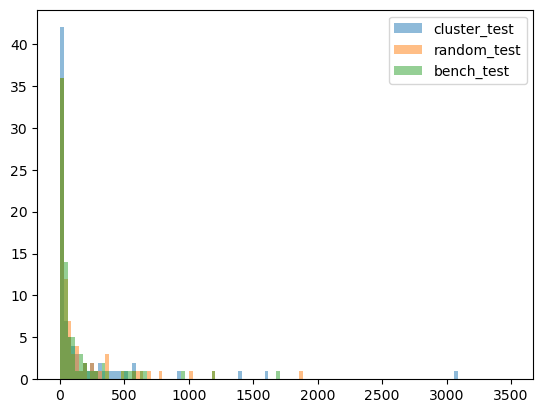

In [38]:
bins = np.linspace(0, 3500, 120)
plt.hist(mses["cluster_test"], bins=bins, alpha=0.5, label="cluster_test")
plt.hist(mses["random_test"], bins=bins, alpha=0.5, label="random_test")
plt.hist(mses["bench_test"], bins =bins, alpha=0.5, label="bench_test")
plt.legend()
# plt.xlim(0,1500)
plt.show()